## Modelling

In [1]:
import logging
import pandas as pd
import os
import sys

# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

# Import the load_data module
try:
    from data_loader import load_data
    logger_initialized = True
except ImportError as e:
    logger_initialized = False
    print(f"Error importing 'load_data': {e}")

# Set pandas display options for better visibility
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [2]:
# Configure logging
def setup_logger(name: str = 'my_logger') -> logging.Logger:
    """
    Set up a logger with INFO level and StreamHandler.
    
    Parameters:
    -----------
    name : str
        The name of the logger.
    
    Returns:
    --------
    logging.Logger
        Configured logger instance.
    """
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    
    # Prevent duplicate handlers
    if not logger.hasHandlers():
        handler = logging.StreamHandler()
        handler.setLevel(logging.INFO)
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        handler.setFormatter(formatter)
        logger.addHandler(handler)
    
    return logger

# Initialize logger
logger = setup_logger()
logger.info("Imported necessary libraries.")

# Check and log if 'load_data' was successfully imported
if logger_initialized:
    logger.info("'load_data' module imported successfully.")
else:
    logger.warning("'load_data' module could not be imported. Check the 'scripts' directory and file availability.")

2025-07-02 11:52:26,562 - INFO - Imported necessary libraries.
2025-07-02 11:52:26,564 - INFO - 'load_data' module imported successfully.


In [5]:


logger.info("🟢 Starting the data loading process...")
df = load_data('../data/data.csv')
if not df.empty:
    logger.info(f"✅ Data loaded successfully! The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
else:
    logger.warning("⚠️ Data loading completed, but the dataset is empty.")



2025-07-02 11:55:12,607 - INFO - 🟢 Starting the data loading process...
2025-07-02 11:55:12,901 - INFO - ✅ Data loaded successfully! The dataset contains 95662 rows and 15 columns.


Data successfully loaded from '../data/data.csv' with 95662 rows and 15 columns.


In [6]:
df_normalized = pd.read_csv('../data/data.csv')

In [7]:
df_normalized.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')

In [9]:


from credit_scoring_model import CreditScoreRFM

# Initialize RFMS object with normalized DataFrame
rfm = CreditScoreRFM(df_normalized.reset_index())



In [10]:
# Calculate Recency, Frequency, and Monetary metrics using the RFM model
rfm_df = rfm.calculate_rfm()

# Display the first five rows of the RFM DataFrame
print("Calculated RFM metrics for the first five customers:")
print("=========================================================")
rfm_df[['CustomerId', 'Recency', 'Frequency', 'Monetary']].head()

Calculated RFM metrics for the first five customers:


,CustomerId,Recency,Frequency,Monetary
0,CustomerId_4406,0,119,109921.75
2,CustomerId_4683,81,2,1000.00
3,CustomerId_988,5,38,228727.20
5,CustomerId_1432,90,1,2000.00
6,CustomerId_2858,5,29,93400.00


In [11]:


# Calculate quartiles explicitly using .loc
rfm_df = rfm_df.copy()  # Ensure you're working on a copy

# Assign R, F, M quartiles
rfm_df.loc[:, 'r_quartile'] = pd.qcut(rfm_df['Recency'], 4, labels=['4', '3', '2', '1'])
rfm_df.loc[:, 'f_quartile'] = pd.qcut(rfm_df['Frequency'], 4, labels=['1', '2', '3', '4'])
rfm_df.loc[:, 'm_quartile'] = pd.qcut(rfm_df['Monetary'], 4, labels=['1', '2', '3', '4'])

# Compute the RFM score
rfm_df.loc[:, 'RFM_Score'] = (
    rfm_df['r_quartile'].astype(int) +
    rfm_df['f_quartile'].astype(int) +
    rfm_df['m_quartile'].astype(int)
)

# Define a risk label based on the RFM score using a threshold
low_threshold = 5  # Example threshold; adjust as needed
rfm_df.loc[:, 'Risk_Label'] = rfm_df['RFM_Score'].apply(
    lambda x: 'Good' if x >= low_threshold else 'Bad'
)

# Select the required columns to display
rfm_df_scores = rfm_df[['CustomerId', 'Recency', 'Frequency', 'Monetary', 'RFM_Score', 'Risk_Label']]
print(rfm_df_scores.head())



        CustomerId  Recency  Frequency   Monetary  RFM_Score Risk_Label
0  CustomerId_4406        0        119  109921.75         12       Good
2  CustomerId_4683       81          2    1000.00          3        Bad
3   CustomerId_988        5         38  228727.20         12       Good
5  CustomerId_1432       90          1    2000.00          3        Bad
6  CustomerId_2858        5         29   93400.00         12       Good


In [12]:
# Create a mapping dictionary
risk_label_mapping = {'Good': 1, 'Bad': 0}

# Fill NaN values with a default value (e.g., 'Bad') before applying the mapping
rfm_df.loc[:, 'Risk_Label'] = rfm_df['Risk_Label'].fillna('Bad')

# Map the Risk_Label to binary values
rfm_df.loc[:, 'Risk_Label'] = rfm_df['Risk_Label'].map(risk_label_mapping)

# Explicitly cast the column to int64 to avoid dtype compatibility issues
rfm_df.loc[:, 'Risk_Label'] = rfm_df['Risk_Label'].astype('int64')

# Extract relevant features for merging
rfm_data = rfm_df[['CustomerId', 'Recency', 'Frequency', 'Monetary', 'Risk_Label']]

# Extract unique rows based on CustomerId
df_normalized_unique = df_normalized.drop_duplicates(subset='CustomerId', keep='first')

# Merge the data
features = pd.merge(df_normalized_unique, rfm_data, on='CustomerId', how='left')

# Set the CustomerId to index
features.set_index('CustomerId', inplace=True)

# Drop the irrelevant features
features.drop(columns=['TransactionStartTime'], inplace=True)

# Set the target variable
target = rfm_df['Risk_Label']

In [13]:
features.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value', 'PricingStrategy',
       'FraudResult', 'Recency', 'Frequency', 'Monetary', 'Risk_Label'],
      dtype='object')

In [18]:
import pandas as pd

# Check if 'Risk_Label' exists and is numeric
if 'Risk_Label' not in features.columns:
    raise ValueError("❌ 'Risk_Label' column not found in your dataset.")

# Convert 'Risk_Label' to numeric if needed (optional depending on data)
features['Risk_Label'] = pd.to_numeric(features['Risk_Label'], errors='coerce')

# Select only numeric columns
numeric_features = features.select_dtypes(include=['number'])

# Check again if 'Risk_Label' is in the numeric set
if 'Risk_Label' not in numeric_features.columns:
    raise ValueError("❌ 'Risk_Label' is not numeric and can't be used in correlation.")

# Calculate the correlation matrix
correlation_matrix = numeric_features.corr()

# Get correlation with target
corr_with_target = correlation_matrix['Risk_Label'].abs()

# Select features with correlation > 0.1
selected_features = corr_with_target[corr_with_target > 0.1].index.tolist()
selected_features.remove('Risk_Label')  # remove target itself

# Filter the original features DataFrame
features = features[selected_features + ['Risk_Label']]


In [19]:
corr_with_target.sort_values(ascending=False).reset_index(name='Correlation with Risk_Label')

,index,Correlation with Risk_Label
0,Risk_Label,1.000000
1,Recency,0.534249
2,PricingStrategy,0.141034
3,Frequency,0.113603
4,Amount,0.049348
5,Value,0.044485
6,Monetary,0.029202
7,FraudResult,0.021644
8,CountryCode,NaN


In [20]:
features.columns

Index(['PricingStrategy', 'Recency', 'Frequency', 'Risk_Label'], dtype='object')

In [21]:


# Separate target and feature variables
X = features
y = target
# Print the shapes of the separated variables
print("Separated features (X) with shape:", X.shape)
print("Separated target (y) with shape:", y.shape)



Separated features (X) with shape: (3742, 4)
Separated target (y) with shape: (3742,)


In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report



In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Check for NaN values in the target variable
if y.isnull().any():
    print("NaN values found in the target variable. Handling NaN values...")

    # Option 1: Drop NaN values
    # Combine features and target for dropping NaNs
    data = pd.concat([X, y], axis=1)
    data = data.dropna()
    
    # Separate features and target again
    X = data.drop(columns=[y.name])  # Replace y.name with the actual name of your target variable if necessary
    y = data[y.name]  # Replace y.name with the actual name of your target variable if necessary

    print("NaN values dropped. New shapes:")
    print("Features (X) shape:", X.shape)
    print("Target (y) shape:", y.shape)

    # Option 2: Fill NaN values (if needed)
    # y.fillna(y.median(), inplace=True)  # Example: Fill with median
    # print("NaN values filled.")

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train and test sets created:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Train and test sets created:
X_train shape: (2993, 4)
X_test shape: (749, 4)
y_train shape: (2993,)
y_test shape: (749,)


In [24]:
from imblearn.over_sampling import SMOTE

# Ensure y_train is of integer type
y_train = y_train.astype(int)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and resample the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Print the shapes of the original and resampled datasets
print("Original training data shapes:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("\nResampled training data shapes:")
print("X_resampled shape:", X_resampled.shape)
print("y_resampled shape:", y_resampled.shape)

Original training data shapes:
X_train shape: (2993, 4)
y_train shape: (2993,)

Resampled training data shapes:
X_resampled shape: (4936, 4)
y_resampled shape: (4936,)


In [25]:
# Define models
print("Defining models...")
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}
print("Models defined:", list(models.keys()))

# Define hyperparameter grids for each model
print("\nDefining hyperparameter grids...")
param_grids = {
    'Logistic Regression': {'classifier__C': [0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'classifier__max_depth': [3, 5, 7, None]},
    'Random Forest': {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [None, 5, 10]},
    'Gradient Boosting': {'classifier__learning_rate': [0.01, 0.1, 0.2], 'classifier__n_estimators': [50, 100, 200]}
}
print("Hyperparameter grids defined for each model.")

# Define pipelines
print("\nCreating pipelines for each model...")
pipelines = {name: Pipeline([
    ('scaler', StandardScaler()),  # Standardize the data
    ('classifier', model)  # The model to be trained
]) for name, model in models.items()}
print("Pipelines created.")

# Set up GridSearchCV for each model pipeline
print("\nSetting up GridSearchCV for each model...")
grid_searches = {
    name: GridSearchCV(estimator=pipeline, param_grid=param_grids[name], cv=5, scoring='accuracy')
    for name, pipeline in pipelines.items()
}
print("GridSearchCV set up for each model pipeline.")

Defining models...
Models defined: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']

Defining hyperparameter grids...
Hyperparameter grids defined for each model.

Creating pipelines for each model...
Pipelines created.

Setting up GridSearchCV for each model...
GridSearchCV set up for each model pipeline.


In [26]:
# Train each pipeline with the resampled dataset
print("Starting training of models with the resampled dataset...\n")
for name, grid_search in grid_searches.items():
    print(f"Training {name} model...")
    grid_search.fit(X_resampled, y_resampled)
    print(f"{name} model trained with best parameters: {grid_search.best_params_}\n")

print("All models have been trained.")

Starting training of models with the resampled dataset...

Training Logistic Regression model...
Logistic Regression model trained with best parameters: {'classifier__C': 0.01}

Training Decision Tree model...
Decision Tree model trained with best parameters: {'classifier__max_depth': 3}

Training Random Forest model...
Random Forest model trained with best parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 50}

Training Gradient Boosting model...
Gradient Boosting model trained with best parameters: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 50}

All models have been trained.


In [27]:
import numpy as np

# Convert y_test to integer type
y_test = y_test.astype(int)

# Verify the data type after conversion
print("Updated y_test data type:", y_test.dtype)
print("y_test data type:", y_test.dtype)
print("Unique values in y_test:", np.unique(y_test))

Updated y_test data type: int64
y_test data type: int64
Unique values in y_test: [0 1]


In [28]:
# Initialize a dictionary to store performance metrics
performance_metrics = {}
y_probs = {}

print("Calculating performance metrics for each model...\n")

for name, pipeline in grid_searches.items():
    print(f"Evaluating {name} model...")
    
    # Predictions on the test set
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    y_probs[name] = y_prob  # Store probabilities for ROC curve

    # Calculate metrics
    performance_metrics[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    }
    
    print(f"{name} model evaluation complete. Metrics calculated:\n{performance_metrics[name]}\n")

print("All models have been evaluated.")

Calculating performance metrics for each model...

Evaluating Logistic Regression model...
Logistic Regression model evaluation complete. Metrics calculated:
{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'ROC AUC': np.float64(1.0)}

Evaluating Decision Tree model...
Decision Tree model evaluation complete. Metrics calculated:
{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'ROC AUC': np.float64(1.0)}

Evaluating Random Forest model...
Random Forest model evaluation complete. Metrics calculated:
{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'ROC AUC': np.float64(1.0)}

Evaluating Gradient Boosting model...
Gradient Boosting model evaluation complete. Metrics calculated:
{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'ROC AUC': np.float64(1.0)}

All models have been evaluated.


In [29]:
# Create a DataFrame from the performance metrics
print("Creating a DataFrame from the performance metrics...")
performance_df = pd.DataFrame(performance_metrics).T

# Display the DataFrame
print("Performance metrics DataFrame created:\n")
performance_df

Creating a DataFrame from the performance metrics...
Performance metrics DataFrame created:



,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,1.0,1.0,1.0,1.0,1.0
Decision Tree,1.0,1.0,1.0,1.0,1.0
Random Forest,1.0,1.0,1.0,1.0,1.0
Gradient Boosting,1.0,1.0,1.0,1.0,1.0


## visualization

Calculating ROC curve for Logistic Regression model...
Calculating ROC curve for Decision Tree model...
Calculating ROC curve for Random Forest model...
Calculating ROC curve for Gradient Boosting model...


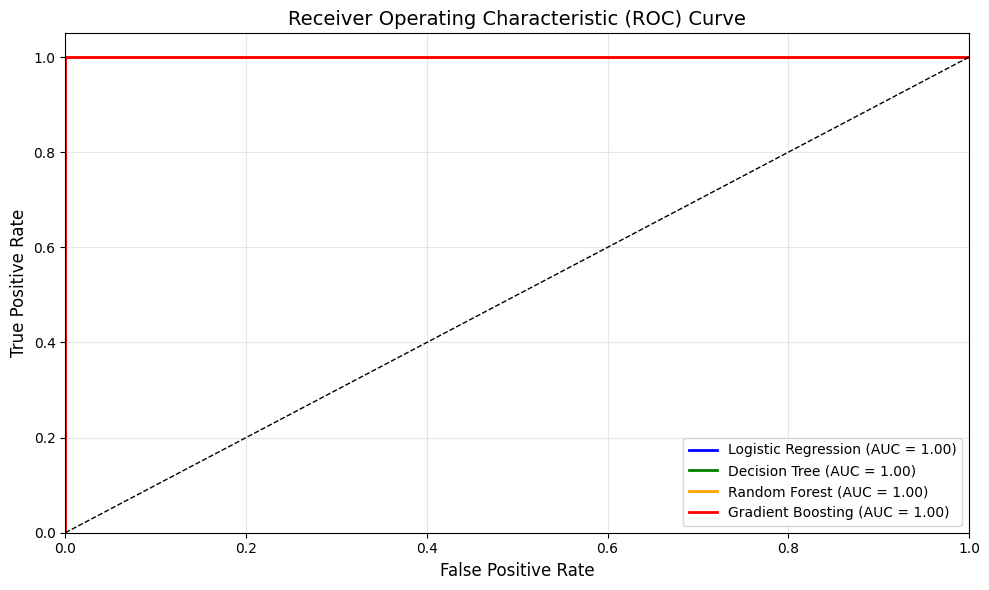

ROC curve plot displayed.


In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Set up the plot
plt.figure(figsize=(10, 6))

# Loop through each model's predicted probabilities
colors = ['blue', 'green', 'orange', 'red']  # Define colors for each model
for (model_name, probs), color in zip(y_probs.items(), colors):
    print(f"Calculating ROC curve for {model_name} model...")
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', color=color, linewidth=2)

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)  # Light grid for better visibility

# Show the plot
plt.tight_layout()
plt.show()
print("ROC curve plot displayed.")